In [1]:
!git clone https://github.com/Jithin06/PolarNet.git

Cloning into 'PolarNet'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 40 (delta 16), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (40/40), 5.37 MiB | 6.49 MiB/s, done.
Resolving deltas: 100% (16/16), done.


In [2]:
cd PolarNet/

/content/PolarNet


In [3]:
pwd

'/content/PolarNet'

In [4]:
import torch
import torch.nn as nn
import numpy as np
from tqdm.autonotebook import tqdm
from polar import PolarCode, get_frozen
from reliability_sequence import Reliability_Sequence
from utils import errors_ber, errors_bler
import matplotlib.pyplot as plt
import random
import os

<ipython-input-4-a4b06a8efe2d>:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
n = 5
N = 2**n
K = 16
snr = 1
batch_size = 64
num_samples = 20000
seed = 42

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(seed)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
g = torch.Generator()
g.manual_seed(seed)

In [16]:
def create_data(num_samples, n, K, snr,rs):
    """
    Parameters:
    - num_samples: Total number of samples to generate
    - batch_size: Batch size for data generation
    - n: Polar code parameter
    - K: Information bit length
    - snr: Signal-to-Noise Ratio
    - rs: Reliability Sequence

    Returns:
    - Saved .npz file with dataset
    """

    msg_bits_list = []
    bpsk_list = []
    codeword_list = []
    corrupted_codeword_list = []

    polar = PolarCode(n, K, rs = rs, use_cuda=False,hard_decision=True)
    # Loop to generate data samples
    for i in range(num_samples):
        msg_bits = (torch.rand(K) > 0.5).float()
        bpsk = 1 - 2 * msg_bits

        codeword = polar.encode(bpsk.unsqueeze(0)).squeeze(0)
        corrupted_codewords = polar.channel(codeword.unsqueeze(0), snr).squeeze(0)

        msg_bits_list.append(msg_bits.cpu().numpy())
        bpsk_list.append(bpsk.cpu().numpy())
        codeword_list.append(codeword.cpu().numpy())
        corrupted_codeword_list.append(corrupted_codewords.cpu().numpy())

        msg_bits_array = np.stack(msg_bits_list)
        bpsk_array = np.stack(bpsk_list)
        codeword_array = np.stack(codeword_list)
        corrupted_codeword_array = np.stack(corrupted_codeword_list)

    filename = f"polar_dataset_N{2**n}_K{K}_SNR{snr}_samples{num_samples}.npz"
    np.savez(filename, msg_bits=msg_bits_array, corrupted_codeword=corrupted_codeword_array, bpsk=bpsk_array, codeword=codeword_array)
    print(f"Dataset saved as {filename}")

In [17]:
create_data(num_samples,n,K,snr,rs=Reliability_Sequence)

Dataset saved as polar_dataset_N32_K16_SNR1_samples20000.npz


In [18]:
class PolarDatasetWithLLRMatrix:
    def __init__(self, data_path, n, K, snr, save_decoded_path=None):
        """
        Dataset that processes polar codes and stores both decoded bits and LLR matrices

        Args:
            data_path (str): Path to the original data file (.npz)
            n (int): Log2 of codeword length (N = 2^n)
            K (int): Information length
            snr (float): Signal-to-noise ratio in dB
            save_decoded_path (str, optional): Path to save the decoded bits for future use
        """
        self.n = n
        self.N = 2**n
        self.K = K
        self.snr = snr

        # Load the original data
        print(f"Loading data from {data_path}")
        data = np.load(data_path)

        # Create polar code object
        self.polar = PolarCode(n, K, rs=Reliability_Sequence, Fr=None, use_cuda=torch.cuda.is_available(), hard_decision=True)

        # Store the data
        self.msg_bits = torch.tensor(data['msg_bits'])
        self.bpsk = torch.tensor(data['bpsk'])
        self.corrupted_codeword = torch.tensor(data['corrupted_codeword'])
        self.codeword = torch.tensor(data['codeword'])

        # Generate decoded bits and LLR matrices in a single pass
        self.decoded_bits = []
        self.llr_matrices = []
        print("Generating decoded bits and LLR matrices for all samples...")

        # First, make a test call to check the number of return values
        test_batch = self.corrupted_codeword[:1]  # Just use the first sample
        device = torch.device('cuda' if torch.cuda.is_available() and hasattr(self.polar, 'device') and self.polar.device.type == 'cuda' else 'cpu')
        test_batch = test_batch.to(device)

        # Try to call sc_decode_new and see what it returns
        try:
            result = self.polar.sc_decode_new(test_batch, snr=self.snr)
            num_returns = len(result) if isinstance(result, tuple) else 1
            print(f"sc_decode_new returns {num_returns} values")

            # Modify our approach based on the return values
            if num_returns == 2:
                # If only 2 returns (likely final_llrs and decoded_bits)
                print("Detected 2-value return pattern - will modify LLR matrix collection")
                collect_llr_matrix_separately = True
            else:
                # Assuming 3 returns as expected
                collect_llr_matrix_separately = False

        except Exception as e:
            print(f"Error during test call: {e}")
            # Default to separate collection if test fails
            collect_llr_matrix_separately = True

        # Process in batches to avoid memory issues
        batch_size = 100
        num_batches = len(self.msg_bits) // batch_size + (0 if len(self.msg_bits) % batch_size == 0 else 1)

        for i in tqdm(range(num_batches)):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, len(self.msg_bits))

            corrupted_batch = self.corrupted_codeword[start_idx:end_idx]
            # Move to appropriate device
            corrupted_batch = corrupted_batch.to(device)

            if collect_llr_matrix_separately:
                try:
                    # Try with return_llr_matrix parameter
                    final_llrs, batch_decoded_bits = self.polar.sc_decode_new(corrupted_batch, snr=self.snr, return_llr_matrix=False)
                except TypeError:
                    # Fall back if parameter doesn't exist
                    final_llrs, batch_decoded_bits = self.polar.sc_decode_new(corrupted_batch, snr=self.snr)

                # Need to define a method to collect LLR matrices separately
                llr_matrix_batch = self._collect_llr_matrices(corrupted_batch, snr=self.snr)
            else:
                try:
                    # Try with return_llr_matrix parameter
                    final_llrs, batch_decoded_bits, llr_matrix_batch = self.polar.sc_decode_new(corrupted_batch, snr=self.snr, return_llr_matrix=True)
                except TypeError:
                    # Fall back if parameter doesn't exist
                    final_llrs, batch_decoded_bits, llr_matrix_batch = self.polar.sc_decode_new(corrupted_batch, snr=self.snr)
                # Debug: check if LLR matrix contains non-zero values
                if torch.all(llr_matrix_batch == 0):
                    print("WARNING: LLR matrix contains all zeros!")
                    print(f"LLR matrix shape: {llr_matrix_batch.shape}")
                    # Try to print some values from final_llrs to confirm LLRs are calculated
                    print(f"Sample final LLRs: {final_llrs[0, :10]}")  # Print first 10 values

            # Store results
            self.decoded_bits.append(batch_decoded_bits.cpu().numpy())
            self.llr_matrices.append(llr_matrix_batch.cpu().numpy())

        # Concatenate batches
        self.decoded_bits = np.concatenate(self.decoded_bits, axis=0)
        self.llr_matrices = np.concatenate(self.llr_matrices, axis=0)

        print(f"Decoded bits shape: {self.decoded_bits.shape}")
        print(f"LLR matrices shape: {self.llr_matrices.shape}")

        # Save the decoded bits for future use if path is provided
        if save_decoded_path:
            print(f"Saving decoded bits to {save_decoded_path}")
            np.savez(
                save_decoded_path,
                decoded_bits=self.decoded_bits,
                info_positions=self.polar.info_positions
            )

        # Calculate and print BER and BLER
        decoded_bits_tensor = torch.tensor(self.decoded_bits)
        ber = errors_ber(self.msg_bits, decoded_bits_tensor).item()
        bler = errors_bler(self.msg_bits, decoded_bits_tensor).item()
        print(f"SC Decoder Performance - BER: {ber:.6f}, BLER: {bler:.6f}")

    def _collect_llr_matrices(self, corrupted_batch, snr):
        """
        Method to separately collect LLR matrices during decoding.
        This needs to be implemented based on how your polar code operates.
        """
        # Since this is highly dependent on the PolarCode implementation,
        # we need to modify the PolarCode class to expose the LLR matrices
        # For now, creating a placeholder matrix of correct size
        batch_size = corrupted_batch.shape[0]
        llr_matrix = torch.zeros((batch_size, self.n+1, self.N), device=corrupted_batch.device)

        # This is where we would collect the actual LLR matrices
        # This may require modifying the PolarCode class

        return llr_matrix

    def __len__(self):
        return len(self.msg_bits)

    def __getitem__(self, idx):
        return {
            'msg_bits': self.msg_bits[idx],
            'bpsk': self.bpsk[idx],
            'corrupted_codeword': self.corrupted_codeword[idx],
            'codeword': self.codeword[idx],
            'decoded_bits': torch.tensor(self.decoded_bits[idx], dtype=torch.float32),
            'llr_matrix': torch.tensor(self.llr_matrices[idx], dtype=torch.float32)
        }

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PolarLLRMatrixNet(nn.Module):
    def __init__(self, n, K, hidden_channels=64):
        super().__init__()
        self.n = n
        self.N = 2**n
        self.K = K

        # CNN layers
        self.conv1 = nn.Conv2d(1, hidden_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(hidden_channels)
        self.conv2 = nn.Conv2d(hidden_channels, hidden_channels*2, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(hidden_channels*2)
        self.pool = nn.MaxPool2d(2, 2)

        # Compute output size after conv layers
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, n + 1, self.N)  # Shape: [B, C, H, W]
            x = self.pool(F.relu(self.bn1(self.conv1(dummy_input))))
            x = F.relu(self.bn2(self.conv2(x)))
            self.flattened_size = x.view(1, -1).shape[1]

        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, hidden_channels*4)
        self.fc2 = nn.Linear(hidden_channels*4, hidden_channels*2)
        self.fc3 = nn.Linear(hidden_channels*2, K)

        # Regularization
        self.dropout = nn.Dropout(0.2)
        self.act = nn.ReLU()

    def forward(self, x):
        # Input: [B, n+1, N]
        x = x.unsqueeze(1)  # [B, 1, n+1, N]
        x = self.act(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.act(self.bn2(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.act(self.fc1(x))
        x = self.dropout(x)
        x = self.act(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [20]:
import os
import torch
import csv
from tqdm import tqdm

def train_llr_matrix_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device,
                           patience=20, n=5, K=16, snr=1.0, log_dir="training_logs"):
    best_val_loss = float('inf')
    trigger_times = 0

    train_loss_values = []
    train_ber_values = []
    train_bler_values = []
    val_loss_values = []
    val_ber_values = []
    val_bler_values = []

    # Logging setup
    os.makedirs(log_dir, exist_ok=True)
    log_path = os.path.join(log_dir, f'train_log_N_{2**n}_K_{K}_SNR_{snr}.csv')
    with open(log_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Epoch', 'Train Loss', 'Val Loss', 'Train BER', 'Val BER', 'Train BLER', 'Val BLER'])

    for epoch in range(num_epochs):
        model.train()
        train_total_loss, train_total_ber, train_total_bler = 0, 0, 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]", leave=False):
            msg_bits = batch['msg_bits'].to(device)
            llr_matrix = batch['llr_matrix'].to(device)

            optimizer.zero_grad()
            outputs = model(llr_matrix)
            loss = criterion(outputs, msg_bits)
            loss.backward()
            optimizer.step()

            predicted_bits = torch.round(torch.sigmoid(outputs))
            ber, bler = calculate_ber_bler(msg_bits, predicted_bits)

            train_total_loss += loss.item()
            train_total_ber += ber
            train_total_bler += bler

        train_avg_loss = train_total_loss / len(train_loader)
        train_avg_ber = train_total_ber / len(train_loader)
        train_avg_bler = train_total_bler / len(train_loader)

        train_loss_values.append(train_avg_loss)
        train_ber_values.append(train_avg_ber)
        train_bler_values.append(train_avg_bler)

        model.eval()
        val_total_loss, val_total_ber, val_total_bler = 0, 0, 0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]", leave=False):
                msg_bits = batch['msg_bits'].to(device)
                llr_matrix = batch['llr_matrix'].to(device)

                outputs = model(llr_matrix)
                loss = criterion(outputs, msg_bits)

                predicted_bits = torch.round(torch.sigmoid(outputs))
                ber, bler = calculate_ber_bler(msg_bits, predicted_bits)

                val_total_loss += loss.item()
                val_total_ber += ber
                val_total_bler += bler

        val_avg_loss = val_total_loss / len(val_loader)
        val_avg_ber = val_total_ber / len(val_loader)
        val_avg_bler = val_total_bler / len(val_loader)

        val_loss_values.append(val_avg_loss)
        val_ber_values.append(val_avg_ber)
        val_bler_values.append(val_avg_bler)

        # Save to log file
        with open(log_path, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([epoch + 1, train_avg_loss, val_avg_loss, train_avg_ber, val_avg_ber, train_avg_bler, val_avg_bler])

        # Save best model
        if val_avg_loss < best_val_loss:
            best_val_loss = val_avg_loss
            trigger_times = 0

            save_dir = f'weights_llr_matrix/N_{2**n}_K_{K}_SNR_{snr}_hidden_{model.fc1.in_features}'
            os.makedirs(save_dir, exist_ok=True)
            torch.save(model.state_dict(), os.path.join(save_dir, f'epoch_{epoch + 1}.pth'))
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print(f"⏹️ Early stopping at epoch {epoch + 1}!")
                break

        # Print progress every epoch
        if ((epoch+1)%5==0):
            print(f"[Epoch {epoch+1}] Train Loss: {train_avg_loss:.4f}, Val Loss: {val_avg_loss:.4f}")
            print(f"              Train BER: {train_avg_ber:.4f}, Val BER: {val_avg_ber:.4f}")
            print(f"              Train BLER: {train_avg_bler:.4f}, Val BLER: {val_avg_bler:.4f}")

    print(f'✅ Training complete. Best val loss: {best_val_loss:.4f} at epoch {epoch + 1 - trigger_times}')
    print(f"📁 Logs saved to: {log_path}")
    return train_loss_values, train_ber_values, train_bler_values, val_loss_values, val_ber_values, val_bler_values

In [21]:
# Utility function for calculating BER and BLER
def calculate_ber_bler(targets, predictions):
    ber = errors_ber(targets, predictions).item()
    bler = errors_bler(targets, predictions).item()
    return ber, bler

# Function to visualize the LLR matrix
def visualize_llr_matrix(llr_matrix, title="LLR Matrix"):
    plt.figure(figsize=(12, 8))
    plt.imshow(llr_matrix, cmap='viridis', aspect='auto')
    plt.colorbar(label='LLR Value')
    plt.title(title)
    plt.xlabel('N (Codeword Length)')
    plt.ylabel('Decoding Stage (log2N + 1)')
    plt.tight_layout()
    plt.show()

In [29]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# Parameters
n = 5
N = 2**n
K = 16
snr = 1
batch_size = 64
num_epochs = 400
learning_rate = 0.001
hidden_channels = 64

In [30]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Path to data
data_path = f'polar_dataset_N{N}_K{K}_SNR{snr}_samples20000.npz'
save_decoded_path = f'decodedbits_dataset_N{N}_K{K}_SNR{snr}_samples20000.npz'

# Step 1: Modify the PolarCode class to include the updated sc_decode_new method
# This would typically be done by editing polar.py directly

# Step 2: Create the dataset with the modified PolarDatasetWithLLRMatrix class
print("Creating dataset...")
dataset = PolarDatasetWithLLRMatrix(data_path, n, K, snr, save_decoded_path)

Creating dataset...
Loading data from polar_dataset_N32_K16_SNR1_samples20000.npz
Generating decoded bits and LLR matrices for all samples...
sc_decode_new returns 3 values


100%|██████████| 200/200 [00:28<00:00,  7.10it/s]


Decoded bits shape: (20000, 16)
LLR matrices shape: (20000, 6, 32)
Saving decoded bits to decodedbits_dataset_N32_K16_SNR1_samples20000.npz
SC Decoder Performance - BER: 0.626959, BLER: 1.000000


In [6]:
data = np.load('polar_dataset_N32_K16_SNR1_samples20000.npz')


In [7]:
msg_bits = data['msg_bits']
corrupted_codeword = data['corrupted_codeword']
bpsk = data['bpsk']
codeword = data['codeword']

In [8]:
print(f"msg_bits shape: {msg_bits.shape}")
print(f"corrupted_codeword shape: {corrupted_codeword.shape}")
print(f"bpsk shape: {bpsk.shape}")
print(f"codeword shape: {codeword.shape}")

msg_bits shape: (20000, 16)
corrupted_codeword shape: (20000, 32)
bpsk shape: (20000, 16)
codeword shape: (20000, 32)


In [9]:
polar = PolarCode(n, K, rs = Reliability_Sequence, use_cuda=False,hard_decision=True)
device = 'cpu'
ber_SC_total=0
bler_SC_total=0
decoded_messages = []
SC_llrs_list = []

for bpsk_bits, corrupted_word in tqdm(zip(bpsk, corrupted_codeword),total=len(bpsk)):
    bpsk_tensor = torch.tensor(bpsk_bits, dtype=torch.float32,device=device).unsqueeze(0)
    corrupted_codeword_tensor = torch.tensor(corrupted_word, dtype=torch.float32,device=device).unsqueeze(0)

    SC_llrs, decoded_SC_msg_bits = polar.sc_decode_old(corrupted_codeword_tensor, snr=snr)

    decoded_messages.append(decoded_SC_msg_bits.squeeze(0).cpu().numpy())
    SC_llrs_list.append(SC_llrs.squeeze(0).cpu().numpy())
    ber_SC = errors_ber(bpsk_tensor,decoded_SC_msg_bits.sign()).item()
    bler_SC = errors_bler(bpsk_tensor,decoded_SC_msg_bits.sign()).item()

    ber_SC_total+=ber_SC
    bler_SC_total+=bler_SC

  0%|          | 0/20000 [00:00<?, ?it/s]

In [10]:
ber_SC_total/len(bpsk),bler_SC_total/len(bpsk)

(0.10668125, 0.25525)

{'msg_bits': tensor([0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1.]), 'bpsk': tensor([ 1., -1.,  1., -1., -1., -1., -1., -1.,  1., -1.,  1., -1.,  1.,  1.,
        -1., -1.]), 'corrupted_codeword': tensor([ 0.2163, -1.7220,  1.6050, -0.6995,  0.5285, -0.1689, -0.3973,  1.1281,
         0.9450, -0.9664,  1.1941,  3.1347,  1.3586,  2.5039, -1.4455, -0.6970,
        -0.1811, -0.8900,  1.5199, -0.5775, -0.7067, -0.3711, -1.5820, -0.8537,
         0.8244, -0.0742, -1.3483,  1.9098, -0.0934, -2.8342,  1.5337, -1.1212]), 'codeword': tensor([ 1., -1.,  1., -1.,  1., -1., -1.,  1., -1., -1.,  1.,  1.,  1.,  1.,
         1.,  1., -1., -1., -1., -1.,  1.,  1., -1., -1.,  1., -1., -1.,  1.,
         1., -1.,  1., -1.]), 'decoded_bits': tensor([ 1., -1.,  1.,  1., -1., -1., -1., -1.,  1.,  1.,  1., -1.,  1.,  1.,
        -1., -1.]), 'llr_matrix': tensor([[-2.0000e+01, -2.0000e+01, -2.0000e+01, -2.0000e+01, -2.0000e+01,
         -1.9998e+01, -1.9966e+01,  1.8643e-01, -2.0000e+01, -2

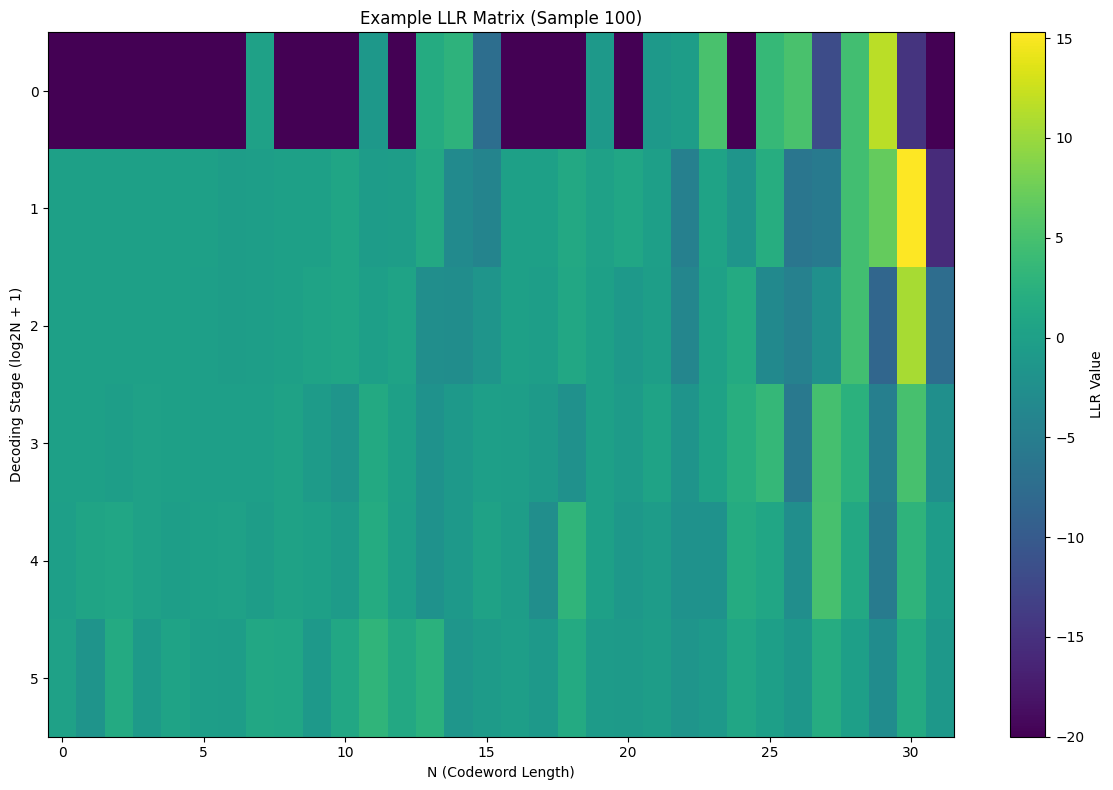

In [31]:
# Visualize an example LLR matrix
sample_idx = 100
sample = dataset[sample_idx]
print(sample)
visualize_llr_matrix(sample['llr_matrix'].numpy(), title=f"Example LLR Matrix (Sample {sample_idx})")

In [32]:
# Split dataset
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size]
)

# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=4
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=4
)

In [33]:
# Initialize the model
model = PolarLLRMatrixNet(n, K, hidden_channels).to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [34]:
# Train the model
train_metrics = train_llr_matrix_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs, device
)

[Epoch 5] Train Loss: 0.4578, Val Loss: 0.4198
              Train BER: 0.2515, Val BER: 0.2220
              Train BLER: 0.8413, Val BLER: 0.6880


[Epoch 10] Train Loss: 0.4213, Val Loss: 0.3814
              Train BER: 0.2294, Val BER: 0.2056
              Train BLER: 0.7954, Val BLER: 0.5850


[Epoch 15] Train Loss: 0.3933, Val Loss: 0.3726
              Train BER: 0.2139, Val BER: 0.1988
              Train BLER: 0.7611, Val BLER: 0.5669


[Epoch 20] Train Loss: 0.3767, Val Loss: 0.3642
              Train BER: 0.2051, Val BER: 0.1915
              Train BLER: 0.7441, Val BLER: 0.5674


[Epoch 25] Train Loss: 0.3572, Val Loss: 0.3690
              Train BER: 0.1940, Val BER: 0.1935
              Train BLER: 0.7211, Val BLER: 0.5776


[Epoch 30] Train Loss: 0.3431, Val Loss: 0.3786
              Train BER: 0.1857, Val BER: 0.1883
              Train BLER: 0.7073, Val BLER: 0.5522


[Epoch 35] Train Loss: 0.3288, Val Loss: 0.3720
              Train BER: 0.1768, Val BER: 0.1832
              Train BLER: 0.6889, Val BLER: 0.5391


[Epoch 40] Train Loss: 0.3156, Val Loss: 0.3661
              Train BER: 0.1697, Val BER: 0.1854
              Train BLER: 0.6819, Val BLER: 0.5635


[Epoch 45] Train Loss: 0.3034, Val Loss: 0.3868
              Train BER: 0.1609, Val BER: 0.1843
              Train BLER: 0.6697, Val BLER: 0.5522


⏹️ Early stopping at epoch 46!
✅ Training complete. Best val loss: 0.3614 at epoch 26
📁 Logs saved to: training_logs/train_log_N_32_K_16_SNR_1.0.csv


In [35]:
len(train_metrics[0])

46

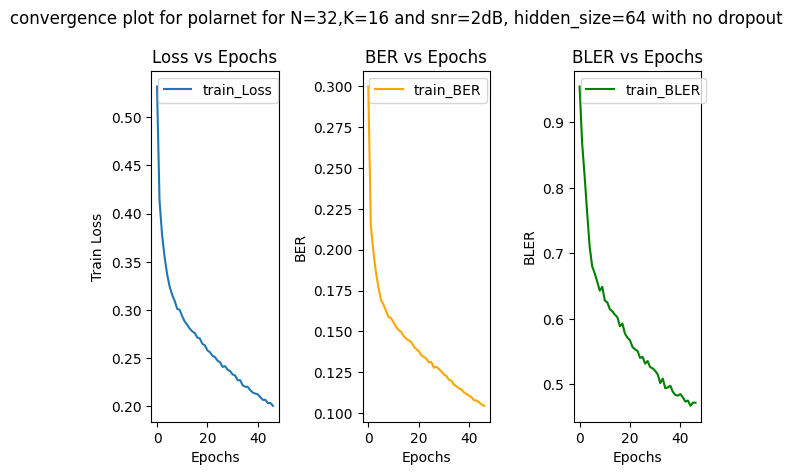

In [28]:
plt.subtitle('convergence plot for polarnet for N=32,K=16 and snr=2dB, hidden_size=64 with no dropout')
# Plot Loss vs Epochs
plt.subplot(1, 3, 1)
plt.plot(train_metrics[0], label='train_Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.legend()

# Plot BER vs Epochs
plt.subplot(1, 3, 2)
plt.plot(train_metrics[1], label='train_BER', color='orange')
plt.title('BER vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('BER')
plt.legend()

# Plot BLER vs Epochs

plt.subplot(1, 3, 3)
plt.plot(train_metrics[2], label='train_BLER', color='green')
plt.title('BLER vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('BLER')
plt.legend()

plt.tight_layout()
plt.show()

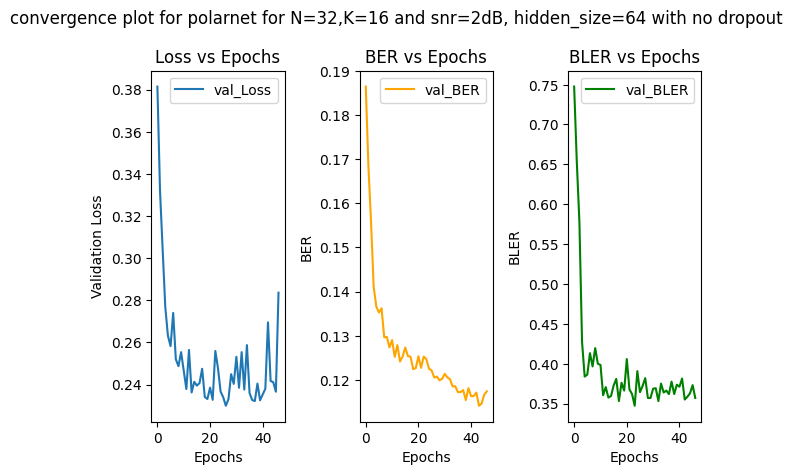

In [29]:
plt.suptitle('convergence plot for polarnet for N=32,K=16 and snr=2dB, hidden_size=64 with no dropout')
# Plot Loss vs Epochs
plt.subplot(1, 3, 1)
plt.plot(train_metrics[3], label='val_Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()

# Plot BER vs Epochs
plt.subplot(1, 3, 2)
plt.plot(train_metrics[4], label='val_BER', color='orange')
plt.title('BER vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('BER')
plt.legend()

# Plot BLER vs Epochs

plt.subplot(1, 3, 3)
plt.plot(train_metrics[5], label='val_BLER', color='green')
plt.title('BLER vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('BLER')
plt.legend()

plt.tight_layout()
plt.show()

In [30]:
model.load_state_dict(torch.load(r'/content/PolarNet/weights_llr_matrix/N_32_K_16_SNR_1.0_hidden_6144/epoch_27.pth'),strict=True)


<All keys matched successfully>

In [31]:
# Initialize PolarCode decoder
polar = PolarCode(n=5, K=16, rs=Reliability_Sequence, use_cuda=torch.cuda.is_available())

# Testing loop for PolarCode decoder
def test_polar_decoder(test_loader, snr):
    test_ber_total, test_bler_total = 0.0, 0.0
    count = 0
    num_batches_to_print = 5  # Print details for first N batches

    with torch.no_grad():
        print(f"Starting testing at SNR={snr}dB...")
        for batch_idx, test_batch in enumerate(test_loader):
            count += 1

            # Get batch data
            msg_bits = test_batch['msg_bits'].to(device)
            corrupted_codeword = test_batch['corrupted_codeword'].to(device)

            # Run through decoder
            final_llrs, decoded_bits, _ = polar.sc_decode_new(corrupted_codeword, snr=snr)

            # Convert decoded bits to same format as msg_bits (0/1)
            decoded_bits_binary = (decoded_bits < 0).float()  # Convert -1/1 to 0/1

            # Calculate metrics
            ber, bler = calculate_ber_bler(msg_bits, decoded_bits_binary)
            test_ber_total += ber
            test_bler_total += bler

            # Print sequences for debugging
            if batch_idx < num_batches_to_print:
                print(f"\nBatch {batch_idx + 1}")
                print(f"Original: {msg_bits[0].int().tolist()}")
                print(f"Decoded:  {decoded_bits_binary[0].int().tolist()}")
                print(f"BER: {ber:.4f}, BLER: {bler:.4f}")
                if torch.all(decoded_bits_binary[0].round() == msg_bits[0]):
                    print("✅ Correct")
                else:
                    print("❌ Errors")

    # Calculate final metrics
    test_avg_ber = test_ber_total / len(test_loader)
    test_avg_bler = test_bler_total / len(test_loader)

    print("\nFinal Results:")
    print(f"Average BER: {test_avg_ber:.6f}")
    print(f"Average BLER: {test_avg_bler:.6f}")
    print(f"Total batches tested: {count}")

    return test_avg_ber, test_avg_bler

# Run the test
test_ber, test_bler = test_polar_decoder(test_loader, snr=2.0)  # SNR in dB

Streaming output truncated to the last 5000 lines.
Output LLRs (non-zero count): 12254/12288
Output LLRs (non-zero count): 12254/12288
Output LLRs (non-zero count): 12254/12288
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 2048/12288
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 3072/12288
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 3584/12288
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 3840/12288
Depth: 1, Bit position: 0
Input LLRs (non-zero count): 3944/12288
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 4008/12288
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 4008/12288
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 4008/12288
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 4008/12288
Depth: 1, Bit position: 0
Input LLRs (non-zero count): 4008/12288
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 4072/12288
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 4072/12288
Depth: 3, Bit position: 0
Input